In [1]:
# paper collect sandbox

In [3]:
from pathlib import Path
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm

data_path = Path("../papers_info")
if not os.path.exists(data_path):
    os.mkdir(data_path)

conference = "iclr"
year = 2023

In [137]:
%%time
titles = []
abstracts = []
years = []
forum_ids = []
decisions = []
authors = []
keywords = []

#for year in [2018, 2019, 2020, 2021, 2022, 2023]:
for year in [2023]:
    for query in ['Blind_Submission', 'Withdrawn_Submission', 'Desk_Rejected_Submission']:
        url = f'https://api.openreview.net/notes?invitation=ICLR.cc%2F{year}%2FConference%2F-%2F{query}'
    
        for offset in [0, 1000, 2000, 3000, 4000]:
            df = pd.DataFrame(requests.get(url + f'&offset={offset}').json()['notes'])
            if len(df) > 0:
                titles    += [d['title'].strip() for d in df['content'].values]
                abstracts += [d['abstract'].strip() for d in df['content'].values]
                keywords  += [d['keywords'] for d in df['content'].values]
                authors   += [', '.join(d['authors']) for d in df['content']]
                years     += [year] * len(df)
                forum_ids += list(df.forum)
                                                
                if query == 'Withdrawn_Submission':
                    decisions += ['Withdrawn'] * len(df)
                elif query == 'Desk_Rejected_Submission':
                    decisions += ['Desk rejected'] * len(df)
                else:
                    decisions += [''] * len(df)
print('')
print(f'Found {len(titles)} papers')

iclr = pd.DataFrame.from_dict({
    'year': np.array(years).astype(int), 
    'id': forum_ids, 
    'title': titles, 
    'abstract': abstracts,
    'authors': authors,
    'decision': decisions,
    'scores': [[]] * len(abstracts),
    'keywords': [[kk.lower() for kk in k] for k in keywords],
})

mask = np.array([len(a) >= 200 for a in iclr.abstract])
iclr = iclr[mask].reset_index(drop=True)
print(f'Removing {np.sum(~mask)} submissions with abstract length below 200 characters.')

iclr.to_pickle(data_path / f'{conference}_{year}.pickle.zip')


Found 4955 papers
Removing 0 submissions with abstract length below 200 characters.
CPU times: user 1.29 s, sys: 428 ms, total: 1.71 s
Wall time: 1min 54s


In [138]:
%%time

# Query the accept/reject decisions and scores. Warning: TAKES A COUPLE OF HOURS

for num, forum_id in enumerate(iclr.id):
    if (num + 1) % 1000 == 0:
        print('*', end='')
    elif (num + 1) % 100 == 0:
        print('.', end='')
        
    forum_url = f'https://api.openreview.net/notes?forum={forum_id}'
    json = requests.get(forum_url).json()

    if iclr.decision[num] == '':
        for i in range(len(json['notes'])):
            if 'decision' in json['notes'][i]['content']:
                decision = json['notes'][i]['content']['decision']
        iclr.at[num, 'decision'] = decision
        
    if iclr.decision[num] != 'Desk rejected':
        scores = []
        for i in range(len(json['notes'])):
            if iclr.year[num] < 2023:
                score_field = 'rating'
            else:
                score_field = 'recommendation'
            if score_field in json['notes'][i]['content']:
                score = int(json['notes'][i]['content'][score_field].split(':')[0])
                scores.append(score)
        iclr.at[num, 'scores'] = scores

print('')

iclr.to_pickle(data_path / f'{conference}_{year}.pickle.zip')

.........*..

KeyboardInterrupt: 

In [ ]:
iclr.shape

(4955, 8)


Found 4955 papers
CPU times: user 872 ms, sys: 133 ms, total: 1.01 s
Wall time: 29 s


Removing 0 submissions with abstract length below 200 characters.


.........*.........*.........*.........*.........
CPU times: user 2min 9s, sys: 9.35 s, total: 2min 19s
Wall time: 56min 23s


/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


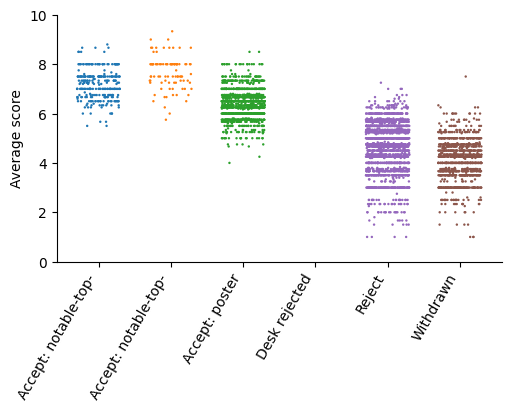

In [ ]:
# Sanity check

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')

avScores = np.array([np.mean(sc) for sc in iclr.scores])

np.random.seed(42)
for num, decision in enumerate(np.unique(iclr.decision)):
    mask = iclr.decision == decision
    ax.scatter(np.random.uniform(num-.3, num+.3, size=np.sum(mask)), avScores[mask], s=3, ec='none')

ax.set_ylim([0,10])
ax.set_ylabel('Average score')
ax.set_xticks(np.arange(np.unique(iclr.decision).size), 
              [d[:20] for d in np.unique(iclr.decision)], rotation=60, ha='right');

sns.despine()

,year,id,title,abstract,authors,decision,scores,keywords
0,2023,RUzSobdYy0V,Quantifying and Mitigating the Impact of Label...,Errors in labels obtained via human annotation...,"Julius Adebayo, Melissa Hall, Bowen Yu, Bobbie...",Accept: poster,"[5, 6, 8]",[]
1,2023,N3kGYG3ZcTi,Suppression helps: Lateral Inhibition-inspired...,Convolutional neural networks (CNNs) have beco...,"Chengyuan Zhuang, Xiaohui Yuan, XUAN GUO",Reject,"[3, 6, 3, 1]","[lateral inhibition, convolutional neural netw..."
2,2023,tmIiMPl4IPa,Factorized Fourier Neural Operators,We propose the Factorized Fourier Neural Opera...,"Alasdair Tran, Alexander Mathews, Lexing Xie, ...",Accept: poster,"[8, 6, 5, 8, 6]","[fourier transform, fourier operators, pde, na..."
3,2023,mhnHqRqcjYU,DFPC: Data flow driven pruning of coupled chan...,"Modern, multi-branched neural network architec...","Tanay Narshana, Chaitanya Murti, Chiranjib Bha...",Accept: poster,"[8, 6, 6]","[pruning, data free, model compression]"
4,2023,sZI1Oj9KBKy,TVSPrune - Pruning Non-discriminative filters ...,"Achieving structured, data-free sparsity of de...","Chaitanya Murti, Tanay Narshana, Chiranjib Bha...",Accept: poster,"[8, 6, 8, 3]","[structured pruning, model compression]"


In [ ]:
# paper visualizer sandbox
from pathlib import Path
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
# visualize by tsne
data_path = Path("../papers_info")
iclr = pd.read_pickle(data_path / 'iclr_2023.pickle.zip')

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
titles_abstracts_together = [iclr.title[i] + ' ' + iclr.abstract[i] for i in range(len(iclr))]

vectorizer = TfidfVectorizer(sublinear_tf=True)
tfidf_features = vectorizer.fit_transform(titles_abstracts_together)

tfidf_features.shape

(4955, 20753)

In [7]:
%%time

# SVD

from sklearn.decomposition import TruncatedSVD

# I tried 50, 100, 300, 600 components, and also not using SVD at all.
# 100 components give the most visually "clustered" t-SNE result
# See below

svd = TruncatedSVD(n_components=100, random_state=42, algorithm='arpack')
svd_data = svd.fit_transform(tfidf_features)

svd_data.shape

CPU times: user 3.64 s, sys: 977 ms, total: 4.62 s
Wall time: 1.48 s


(4955, 100)

In [8]:
from sklearn.manifold import TSNE
import umap

/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/shun/Library/Caches/pypoetry/virtualenvs/papers-visualization-wtOSKkz2-py3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

In [144]:
%time papers_embed_tsne_svd = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(svd_data)
%time papers_embed_tsne_tfid = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(tfidf_features)
%time papers_embed_umap_svd = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine').fit_transform(svd_data)
%time papers_embed_umap_tfid = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine').fit_transform(tfidf_features)

CPU times: user 1min 34s, sys: 4.74 s, total: 1min 39s
Wall time: 18 s
CPU times: user 6min 13s, sys: 4.45 s, total: 6min 18s
Wall time: 56.5 s
CPU times: user 17.1 s, sys: 653 ms, total: 17.7 s
Wall time: 4.59 s
CPU times: user 46.5 s, sys: 603 ms, total: 47.1 s
Wall time: 8.71 s


In [70]:
model

LongformerModel(
  (embeddings): LongformerEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
  )
  (encoder): LongformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x LongformerLayer(
        (attention): LongformerAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
    

In [88]:
a = model.embeddings.word_embeddings(input_ids)

In [91]:
a.shape

torch.Size([1, 187, 768])

In [9]:
from transformers import LongformerModel, AutoTokenizer
import torch

model = LongformerModel.from_pretrained("allenai/longformer-base-4096")
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [69]:
model

LongformerModel(
  (embeddings): LongformerEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
  )
  (encoder): LongformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x LongformerLayer(
        (attention): LongformerAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
    

In [10]:
papers_embed_bert = []
for title_and_abstract in tqdm(titles_abstracts_together):
    input_ids = torch.tensor(tokenizer.encode(title_and_abstract)).unsqueeze(0)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)
    outputs = model(input_ids, attention_mask=attention_mask)
    sequence_output = outputs.last_hidden_state
    pooled_output = outputs.pooler_output
    papers_embed_bert.append(pooled_output[0].detach().numpy())
papers_embed_bert = np.array(papers_embed_bert)

  0%|          | 0/4955 [00:00<?, ?it/s]

In [54]:
papers_embed_bert_ = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(papers_embed_bert)
#papers_embed_bert_ = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='cosine').fit_transform(papers_embed_bert)

In [55]:
papers_embed = papers_embed_bert_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


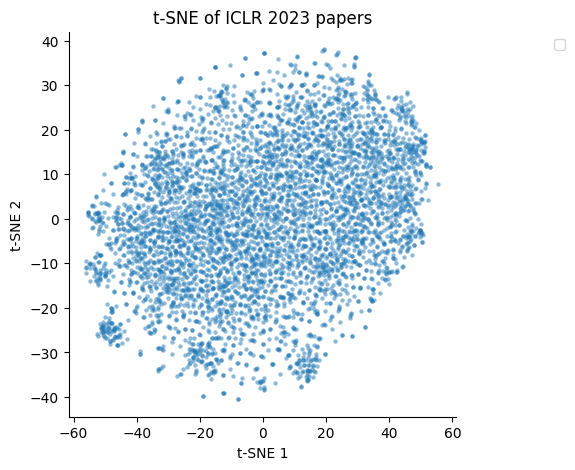

In [63]:
fig,ax = plt.subplots(figsize=(5,5))
# seabornを使ってpapers_embedをプロット
#sns.scatterplot(x=papers_embed[:,0], y=papers_embed[:,1], hue=iclr.decision, s=10, linewidth=0, alpha=0.5, ax=ax)
sns.scatterplot(x=papers_embed[:,0], y=papers_embed[:,1], s=10, linewidth=0, alpha=0.5, ax=ax)
ax.set_title('t-SNE of ICLR 2023 papers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), ncol=1)
sns.despine()


In [64]:
### titleのキーワードを抽出
keywords = []
words, counts = np.unique(' '.join(iclr.title).lower().split(), return_counts=True)
ind = np.argsort(counts)[::-1][:30]
for i in ind:
    if len(words[i]) >= 5: 
        print(f'{words[i]:20} {counts[i]:4}')
        keywords.append(words[i])

### 不要そうなキーワードを削除
if "learning" in keywords:keywords.remove('learning')
if "neural" in keywords:keywords.remove('neural')
if "networks" in keywords:keywords.remove('networks')
if "models" in keywords:keywords.remove('models')
if "model" in keywords:keywords.remove('model')

learning             1527
neural                578
networks              363
models                349
graph                 288
reinforcement         262
representation        203
training              195
model                 188
language              184
federated             177
efficient             171
adversarial           168
image                 163
optimization          157
using                 156
contrastive           146


In [65]:
keywords = np.array(keywords)

# glasbey.create_palette(palette_size=32)
labelColors = ['#d21820', '#1869ff', '#008a00', '#f36dff', '#710079', '#aafb00', 
               '#00bec2', '#ffa235', '#5d3d04', '#08008a', '#005d5d', '#9a7d82', 
               '#a2aeff', '#96b675', '#9e28ff', '#4d0014', '#ffaebe', '#ce0092', 
               '#00ffb6', '#002d00', '#9e7500', '#3d3541', '#f3eb92', '#65618a', 
               '#8a3d4d', '#5904ba', '#558a71', '#b2bec2', '#ff5d82', '#1cc600', 
               '#92f7ff', '#2d86a6']
labelColors = np.array(labelColors)

counts = [np.sum([keyword in t.lower() for t in iclr.title]) for keyword in keywords]
ind = np.argsort(counts)[::-1][:30]
for i in ind:
    print(f'{keywords[i]:20} {counts[i]:4}')
    
print('')
print(f'{keywords.size} labels')


graph                 363
representation        349
training              306
reinforcement         265
efficient             238
image                 228
language              228
adversarial           178
federated             177
optimization          165
using                 161
contrastive           150

12 labels


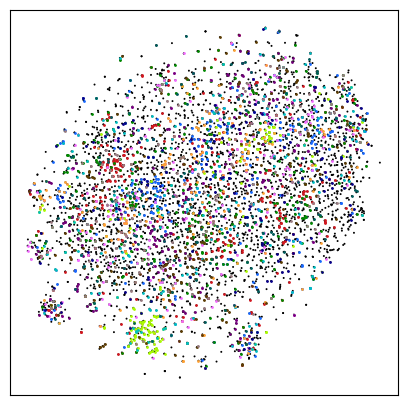

In [66]:
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(papers_embed[:,0],papers_embed[:,1],s=2,c="k",ec="none")
ax.set_xticks([])
ax.set_yticks([])

for num, keyword in enumerate(keywords):
    ind = [i for i,t in enumerate(iclr.title) if keyword.lower() in t.lower()]
    ax.scatter(papers_embed[ind,0], papers_embed[ind,1], s=1, c=labelColors[num])

In [60]:
from sklearn.neighbors import KernelDensity

Text(-18.948069, 2.0601916, 'reinforcement')

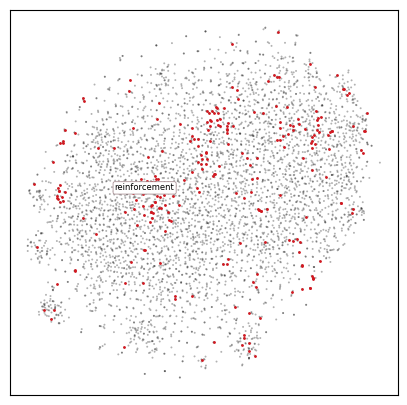

In [67]:
# one keyword 
keyword = "reinforcement"

fig,ax = plt.subplots(figsize=(5,5))
ax.scatter(papers_embed[:,0],papers_embed[:,1],s=2,c="k",ec="none",alpha=0.3)
ax.set_xticks([])
ax.set_yticks([])

idx = [i for i,t in enumerate(iclr.title) if keyword.lower() in t.lower()]

ax.scatter(papers_embed[idx,0], papers_embed[idx,1], s=1, c=labelColors[0])

if np.sum(idx) > 500:
    bw = 10
else:
    bw = 2

kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(papers_embed[idx])
log_density = kde.score_samples(papers_embed[idx])
mode = papers_embed[idx][np.argmax(log_density)]
mode += mode / np.linalg.norm(mode) * 5
if keyword == 'translation':
    mode[0] += 5
if mode[0] > 65:
    mode[0] -= 5
ax.text(mode[0], mode[1], keyword, ha='center', va='center', c='k', fontsize=6,
            bbox=dict(facecolor='w', alpha=1, edgecolor=labelColors[num], 
                        boxstyle='round, pad=.2', linewidth=.5))

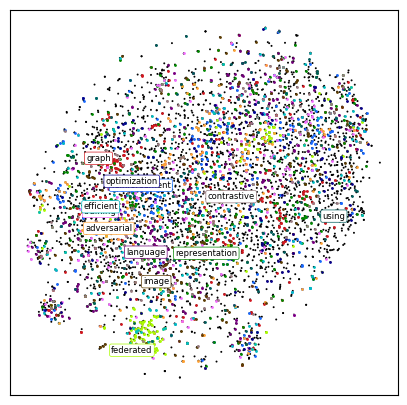

In [62]:
from sklearn.neighbors import KernelDensity

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(papers_embed[:,0],papers_embed[:,1],s=2,c="k",ec="none")
ax.set_xticks([])
ax.set_yticks([])

for num, keyword in enumerate(keywords):
    ind = [i for i,t in enumerate(iclr.title) if keyword.lower() in t.lower()]
    ax.scatter(papers_embed[ind,0], papers_embed[ind,1], s=1, c=labelColors[num])

for num, keyword in enumerate(keywords):
    idx = [keyword.lower() in t.lower() for t in iclr.title]
    if np.sum(idx) > 500:
        bw = 10
    else:
        bw = 2    
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(papers_embed[idx])
    log_density = kde.score_samples(papers_embed[idx])
    mode = papers_embed[idx][np.argmax(log_density)]
    mode += mode / np.linalg.norm(mode) * 5
    if keyword == 'translation':
        mode[0] += 5
    if mode[0] > 65:
        mode[0] -= 5
    ax.text(mode[0], mode[1], keyword, ha='center', va='center', c='k', fontsize=6,
                bbox=dict(facecolor='w', alpha=1, edgecolor=labelColors[num], 
                          boxstyle='round, pad=.2', linewidth=.5))